<a href="https://colab.research.google.com/github/Mrwan-Atef/dino-neuromatch/blob/main/SaliencyDinoResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# --- 1. Setup: Device and Model Loading ---

# Set device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the DINO ResNet-50 model from the official Facebook Research hub
# This model was trained using the DINO self-supervised method.
try:
    model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
    model.to(device)
    model.eval() # Set the model to evaluation mode
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure you have an internet connection and the latest version of PyTorch.")
    exit()



Using device: cuda


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully.


In [ ]:
# --- 2. Image Loading and Preprocessing ---

# Use a sample image URL for reproducibility
url = "https://salient-imagenet.cs.umd.edu/feature_visualization/class_895/feature_1257/images/0.jpg"
try:
    img_pil = Image.open(requests.get(url, stream=True).raw).convert("RGB")
    print("Image downloaded successfully.")
except Exception as e:
    print(f"Error downloading image: {e}")
    exit()

# DINO models require specific normalization.
# These are the standard ImageNet statistics.
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image and add a batch dimension
input_tensor = preprocess(img_pil).unsqueeze(0).to(device)

# We need to compute the gradient with respect to the input image, so we set requires_grad=True
input_tensor.requires_grad = True


Image downloaded successfully.


In [ ]:
# --- 3. Saliency Map Calculation ---

# Forward pass: get the model's output feature vector
output_features = model(input_tensor)

# To get a single scalar value for backpropagation, we compute the L2 norm of the feature vector.
# This represents the "strength" of the model's feature representation for the image.
score = torch.norm(output_features)

# Zero out any previous gradients
model.zero_grad()

# Backward pass: compute the gradient of the score with respect to the input tensor
score.backward()

# Get the gradients from the input tensor
# The .grad attribute contains the gradients we need.
saliency_map_raw = input_tensor.grad.data

# Process the gradients to create a viewable saliency map
# 1. Take the absolute value of the gradients
# 2. Take the maximum value across the color channels to get a 2D map
saliency_map = torch.log(saliency_map_raw.abs() + 1)
saliency_map, _ = torch.max(saliency_map.abs(), dim=1) # Shape: [1, 224, 224]

# Squeeze to remove the batch dimension and move to CPU for plotting
saliency_map = saliency_map.squeeze(0).cpu().numpy()

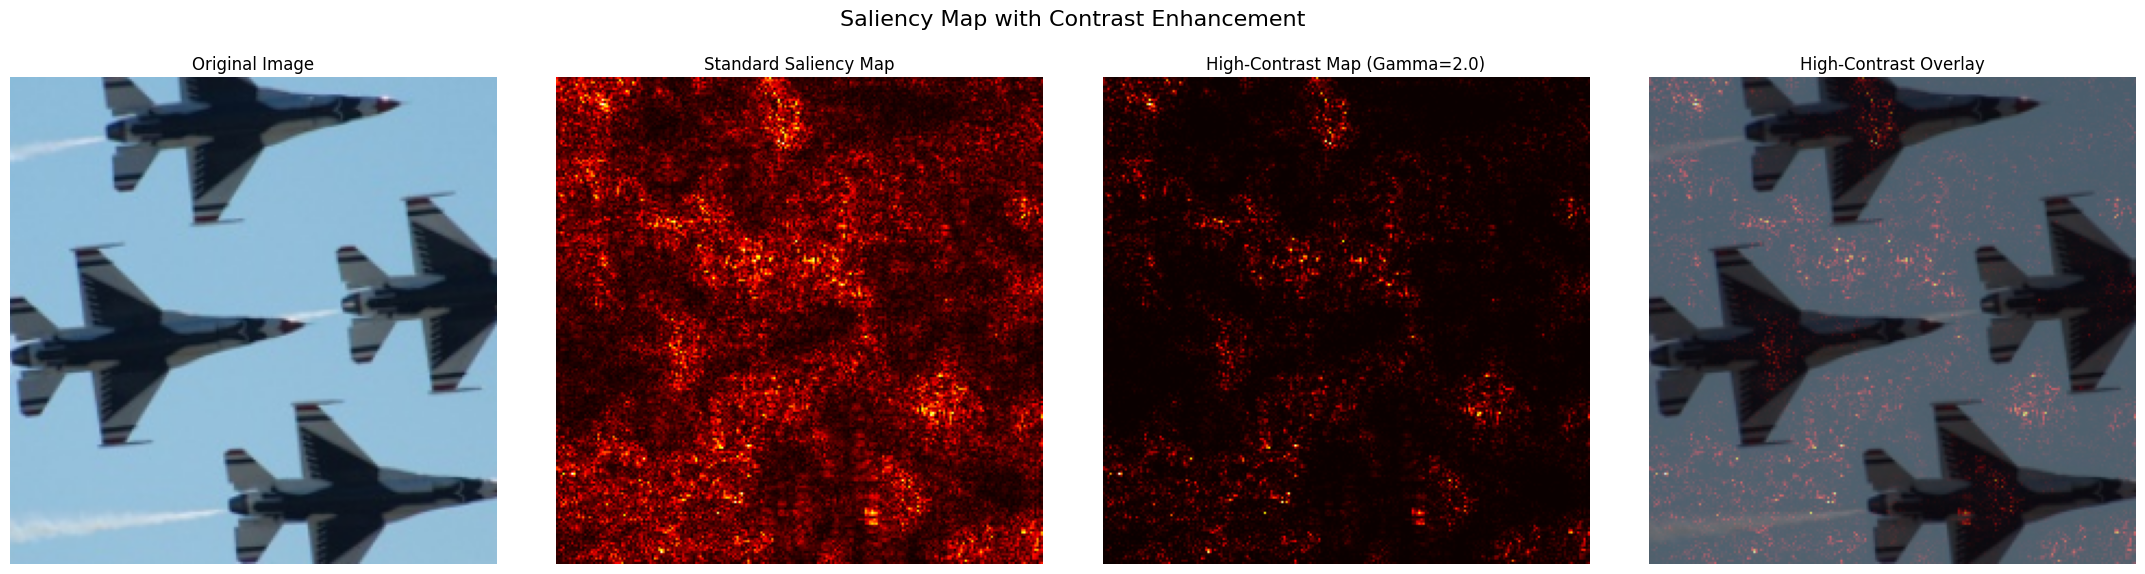

In [ ]:
# --- 4. Visualization with Enhanced Contrast ---

# Normalize the saliency map for visualization (from 0 to 1)
saliency_map_normalized = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# A gamma value > 1 will make highlights stand out more.
# Common values are between 1.5 and 2.5. Let's use 2.0.
gamma = 2.0
saliency_map_high_contrast = np.power(saliency_map_normalized, gamma)


# We need the original image for display, but without normalization
display_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])
display_img = display_transform(img_pil)

# Create a figure to display the results (now with 4 plots)
fig, axes = plt.subplots(1, 4, figsize=(22, 6))
plt.suptitle('Saliency Map with Contrast Enhancement', fontsize=16)

# Plot Original Image
axes[0].imshow(display_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot Standard Saliency Map
im1 = axes[1].imshow(saliency_map_normalized, cmap='hot')
axes[1].set_title('Standard Saliency Map')
axes[1].axis('off')

# Plot High-Contrast Saliency Map
im2 = axes[2].imshow(saliency_map_high_contrast, cmap='hot')
axes[2].set_title(f'High-Contrast Map (Gamma={gamma})')
axes[2].axis('off')

# Plot Overlay using the high-contrast map
axes[3].imshow(display_img)
axes[3].imshow(saliency_map_high_contrast, cmap='hot', alpha=0.5) # Using the new map
axes[3].set_title('High-Contrast Overlay')
axes[3].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Setup: Device, Image, and Preprocessing ---

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Use the same sample image URL
url = "https://salient-imagenet.cs.umd.edu/feature_visualization/class_628/feature_1055/images/0.jpg"
try:
    img_pil = Image.open(requests.get(url, stream=True).raw).convert("RGB")
    print("Image downloaded successfully.")
except Exception as e:
    print(f"Error downloading image: {e}")
    exit()

# Preprocessing is the same for both models
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image and enable gradient calculation
input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
input_tensor.requires_grad = True


# --- 2. Model Loading ---

# Load DINO ResNet-50
model_dino = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50', verbose=False)
model_dino.to(device)
model_dino.eval()
print("DINO ResNet-50 loaded.")

# Load standard Supervised ResNet-50 (pretrained on ImageNet)
weights = models.ResNet50_Weights.IMAGENET1K_V2
model_supervised = models.resnet50(weights=weights)
model_supervised.to(device)
model_supervised.eval()
print("Supervised ResNet-50 loaded.")

Using device: cuda
Image downloaded successfully.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DINO ResNet-50 loaded.
Supervised ResNet-50 loaded.



--- Calculating Saliency for DINO ---
DINO Score (L2 Norm): 8.102465629577637

--- Calculating Saliency for Supervised ResNet ---
Supervised Model Prediction: 'liner' (ID: 628)
Score for this class: 6.568600177764893


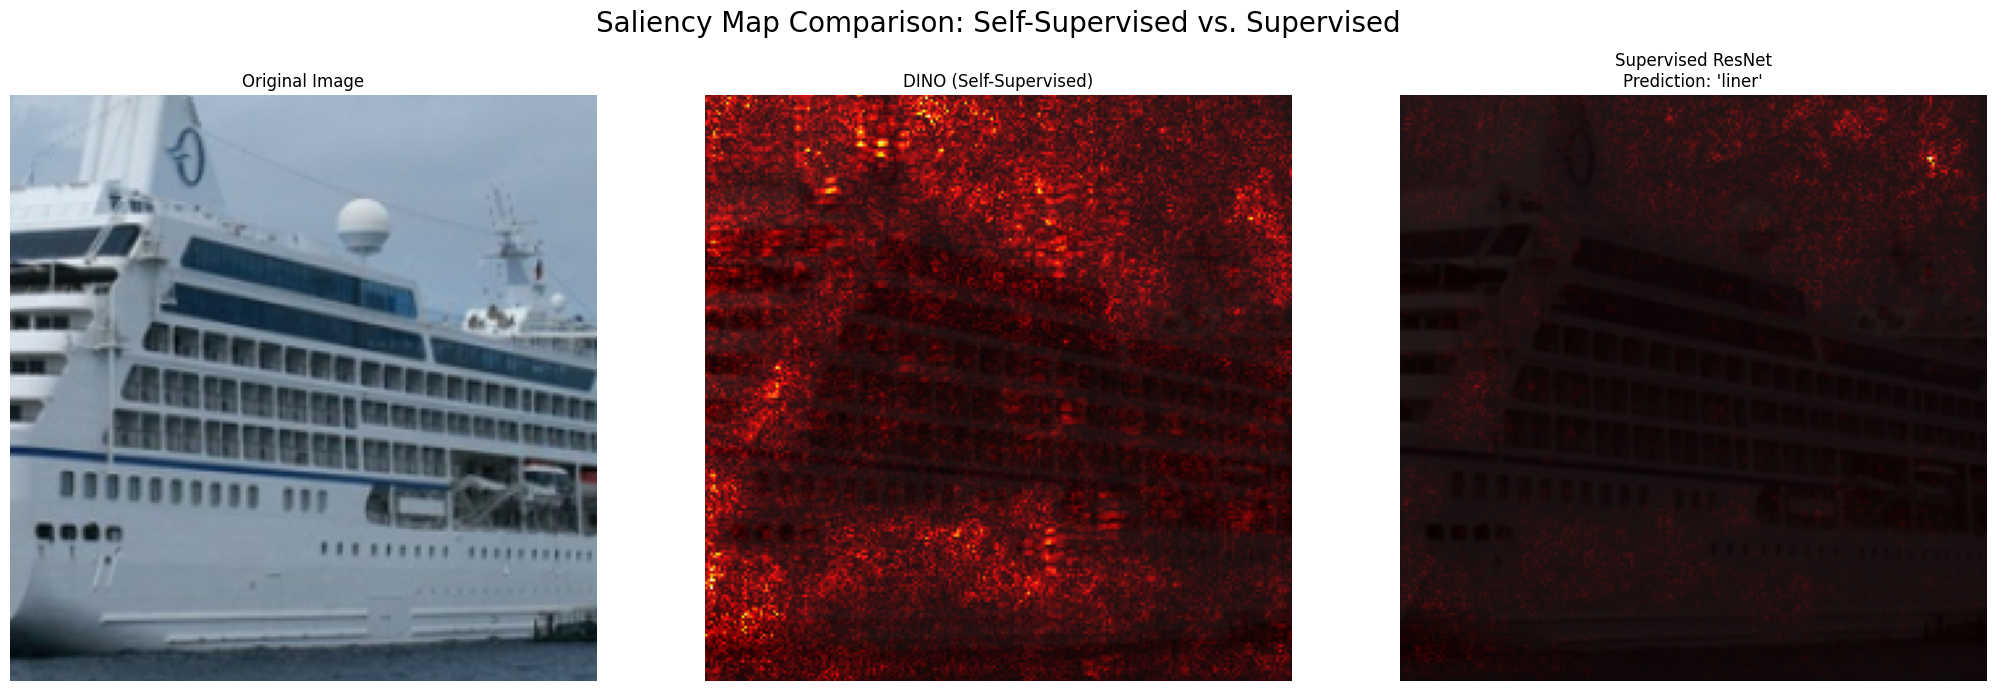

In [ ]:
# --- 3. Saliency Calculation for DINO Model ---
# Preprocess the image and enable gradient calculation
input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
input_tensor.requires_grad = True

print("\n--- Calculating Saliency for DINO ---")
output_dino = model_dino(input_tensor)
# For self-supervised models, we use the L2 norm of the feature vector as the score
score_dino = torch.norm(output_dino)
print("DINO Score (L2 Norm):", score_dino.item())

# Backpropagate to get gradients
model_dino.zero_grad()
score_dino.backward()

# The gradients are now in input_tensor.grad
saliency_dino_raw = input_tensor.grad.data.clone() # Clone to save it

# CRITICAL: Zero out gradients on the input tensor before the next model
input_tensor.grad.zero_()


# --- 4. Saliency Calculation for Supervised Model ---

print("\n--- Calculating Saliency for Supervised ResNet ---")
output_supervised = model_supervised(input_tensor)
# For supervised models, we use the score of the predicted class
score_max, predicted_id = torch.max(output_supervised, 1)
predicted_class = weights.meta['categories'][predicted_id.item()]
print(f"Supervised Model Prediction: '{predicted_class}' (ID: {predicted_id.item()})")
print(f"Score for this class:", score_max.item())


# Backpropagate from the score of the winning class
model_supervised.zero_grad()
score_max.backward()

saliency_supervised_raw = input_tensor.grad.data.clone()


# --- 5. Processing and Visualization ---

def process_and_enhance(raw_map, gamma=2.0):
    """Helper function to process raw gradients into a viewable high-contrast map."""
    # 1. Take absolute max across color channels
    saliency, _ = torch.max(raw_map.abs(), dim=1)
    saliency = saliency.squeeze(0).cpu().numpy()

    # 2. Normalize to [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # 3. Apply power-law for contrast
    saliency = np.power(saliency, gamma)
    return saliency

# Process both maps for high contrast
gamma = 1
saliency_dino_processed = process_and_enhance(saliency_dino_raw, gamma=gamma)
saliency_supervised_processed = process_and_enhance(saliency_supervised_raw, gamma=gamma)

# Get the original image for display
display_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])
display_img = display_transform(img_pil)

# Create the comparison plot
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
plt.suptitle('Saliency Map Comparison: Self-Supervised vs. Supervised', fontsize=20)

# Plot Original Image
axes[0].imshow(display_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot DINO Saliency
axes[1].imshow(display_img)
axes[1].imshow(saliency_dino_processed, cmap='hot', alpha=0.9)
axes[1].set_title('DINO (Self-Supervised)')
axes[1].axis('off')

# Plot Supervised ResNet Saliency
axes[2].imshow(display_img)
axes[2].imshow(saliency_supervised_processed, cmap='hot', alpha=0.9)
axes[2].set_title(f"Supervised ResNet\nPrediction: '{predicted_class}'")
axes[2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()